# Basic web scraping

Scraping the blogs of Frame.io

In [1]:
import requests
from bs4 import BeautifulSoup
from dateutil import parser

In [26]:
#header dictionary
headers = {
    'user-agent':'Chrome/56.0.292487',
    'referrer':'https://google.com'
}

In [27]:
url = 'https://blog.frame.io/2018/10/01/'
r = requests.get(url,headers=headers)
r.status_code

200

In [28]:
html = r.text.strip() #strip - removes spaces
soup = BeautifulSoup(html,'lxml')


In [8]:
header = soup.find(class_='entry-header')
title_html = header.find(class_='post-meta-title')


In [13]:
def parse_page(url):
    r = requests.get(url, headers=headers)
    html = r.text.strip()
    soup = BeautifulSoup(html, 'lxml')
    
    # Header Content
    header = soup.find(class_='entry-header')
    read_time = extract_read_time(header)
    title = extract_title(header)

    author = extract_author(header)
    categories = extract_categories(header)

    date = extract_date(header)
    dt = parser.parse(date)
    month = dt.strftime("%B")
    weekday = dt.strftime("%A")
    
    # Body Content
    content = soup.find(class_='entry-content')
    word_count = len(content.text.split())
    #reading_level = textstat.flesch_kincaid_grade(content.text)

    links = content.find_all("a")
    link_count = len(links)

    images = content.find_all("img")
    image_count = len(images)
    
    page_data = {
        'reading_time' : read_time,
        'title': title,
        'date': date,
        'month': month,
        'weekday': weekday,
        'author': author,
        'categories': categories,
        'word_count': word_count,
        #'reading_level': reading_level,
        'link_count': link_count,
        'image_count': image_count
    }
    
    return page_data
    
def extract_read_time(header):
    html_str = header.find(class_='read-time')
    time_str = html_str.contents[0].strip().lower().split()[0]
    time_int = int(time_str)
    return time_int

def extract_title(header):
    html_str = header.find(class_='post-meta-title')
    title_str = html_str.contents[0].strip()
    return title_str

def extract_date(header):
    html_str = header.find(class_='single-post-date')
    date_str = html_str.contents[0].strip()
    return date_str

def extract_author(header):
    html_str = header.find(class_='author-name')
    author_str = html_str.find('a').contents[0].strip()
    return author_str

def extract_categories(header):
    html_str = header.find(class_='single-post-cat')
    categories = html_str.findAll('a')
    cat_names = []
    for cat_link in categories:
        cat_name = cat_link.contents[0].strip().lower()
        cat_names.append(cat_name)
    return cat_names

In [55]:
articles_store = []

In [56]:
def parse_category(url):
    r = requests.get(url, headers=headers)
    html = r.text.strip()
    soup = BeautifulSoup(html, 'lxml')
    
    article_cards = soup.findAll(class_='post-content')

    for article in article_cards:
        title = article.find(class_='post-meta-title')
        link = title.contents[0]['href']
        #print('Parsing URL:', link)
        page = parse_page(link)
        articles_store.append(page)
        
    next_link = find_next_link(soup)
    
    if next_link is not None:
        #print('Next page:', next_link)
        parse_category(next_link)
        
    return None

def find_next_link(soup_item):
    bottom_nav = soup_item.find(class_='navigation')
    
    if bottom_nav == None:
        return None
    
    links = bottom_nav.findAll('a')
    next_page = links[-1]

    if next_page.contents[0] == 'Next':
        next_link = next_page['href']
        return next_link
    
    return None

In [57]:
bts = 'https://blog.frame.io/category/behind-the-scenes/'
parse_category(bts)

In [58]:
author_list = []
author_dict = {}
for i in range(len(articles_store)):
    #print(articles_store[i].get('author'))
    author= articles_store[i].get('author')
    author_list.append(author)


In [59]:
author_dict = {}
for i in author_list:
    #print(author_list.count(i))
    author_dict.setdefault(i,author_list.count(i))

In [60]:
#    author_dict.setdefault(author,author.count(author[i]))
print(author_dict)

{u'Scott Strandberg': 1, u'Lisa McNamara': 11, u'Jason Boone': 1, u'Alexander Huls': 7, u'Ron Dawson': 3, u'Andy Young': 1, u'Christian Leithart': 1, u'Mark Christiansen': 6}


In [61]:
import matplotlib.pyplot as plt

Text(0.5,1,'The most popular author:')

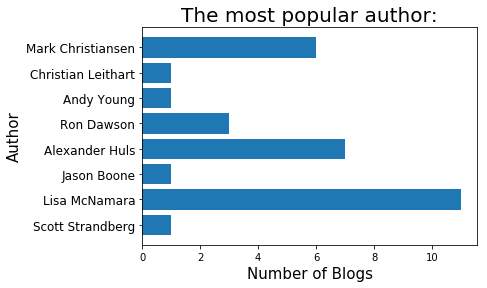

In [62]:
%matplotlib inline
plt.barh(range(len(author_dict)), list(author_dict.values()))
plt.yticks(range(len(author_dict)), list(author_dict.keys()), fontsize=12)
plt.ylabel('Author', fontsize=15)
plt.xlabel('Number of Blogs', fontsize=15)
plt.title('The most popular author:', fontsize=20)

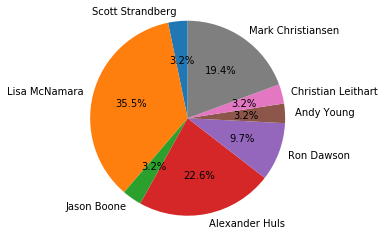

In [63]:
fig1, ax1 = plt.subplots()
ax1.pie(author_dict.values(), labels=author_dict.keys(), autopct='%1.1f%%',startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Reference: Udemy course: Simple Blogging Analytics Dashboard in Python. Created by Ty Shaikh